### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 1000
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 0  # penaliza los errores
alpha_inc = 0 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:14<103:55:30, 74.84s/it]

Entrenando:   0%|          | 2/5000 [02:28<102:57:06, 74.15s/it]

Entrenando:   0%|          | 3/5000 [03:42<102:53:23, 74.13s/it]

Entrenando:   0%|          | 4/5000 [04:56<102:47:57, 74.07s/it]

Entrenando:   0%|          | 5/5000 [06:10<102:29:57, 73.87s/it]

Entrenando:   0%|          | 6/5000 [07:24<102:37:08, 73.97s/it]

Entrenando:   0%|          | 7/5000 [08:37<102:28:18, 73.88s/it]

Entrenando:   0%|          | 8/5000 [09:51<102:24:19, 73.85s/it]

Entrenando:   0%|          | 9/5000 [11:06<102:44:33, 74.11s/it]

Entrenando:   0%|          | 10/5000 [12:20<102:41:33, 74.09s/it]

Entrenando:   0%|          | 11/5000 [13:34<102:41:51, 74.11s/it]

Entrenando:   0%|          | 12/5000 [14:49<102:52:29, 74.25s/it]

Entrenando:   0%|          | 13/5000 [16:03<102:48:07, 74.21s/it]

Entrenando:   0%|          | 14/5000 [17:17<102:49:28, 74.24s/it]

Entrenando:   0%|          | 15/5000 [18:31<102:41:38, 74.16s/it]

Entrenando:   0%|          | 16/5000 [19:45<102:42:25, 74.19s/it]

Entrenando:   0%|          | 17/5000 [21:01<103:29:35, 74.77s/it]

Entrenando:   0%|          | 18/5000 [22:16<103:21:02, 74.68s/it]

Entrenando:   0%|          | 19/5000 [23:35<105:09:09, 76.00s/it]

Entrenando:   0%|          | 20/5000 [25:23<118:13:39, 85.47s/it]

Entrenando:   0%|          | 21/5000 [27:07<126:13:15, 91.26s/it]

Entrenando:   0%|          | 22/5000 [29:07<137:56:12, 99.75s/it]

Entrenando:   0%|          | 23/5000 [31:17<150:39:30, 108.98s/it]

Entrenando:   0%|          | 24/5000 [33:25<158:26:13, 114.62s/it]

Entrenando:   0%|          | 25/5000 [35:35<164:41:32, 119.17s/it]

Entrenando:   1%|          | 26/5000 [37:43<168:27:29, 121.92s/it]

Entrenando:   1%|          | 27/5000 [40:17<181:32:39, 131.42s/it]

Entrenando:   1%|          | 28/5000 [43:41<211:28:42, 153.12s/it]

Entrenando:   1%|          | 29/5000 [47:05<232:46:55, 168.58s/it]

Entrenando:   1%|          | 30/5000 [50:28<246:55:46, 178.86s/it]

Entrenando:   1%|          | 31/5000 [53:43<253:20:31, 183.54s/it]

Entrenando:   1%|          | 32/5000 [57:05<260:57:59, 189.11s/it]

Entrenando:   1%|          | 33/5000 [1:00:21<263:41:30, 191.12s/it]

Entrenando:   1%|          | 34/5000 [1:04:27<286:43:08, 207.85s/it]

Entrenando:   1%|          | 35/5000 [1:08:43<306:24:23, 222.17s/it]

Entrenando:   1%|          | 36/5000 [1:12:51<316:53:36, 229.82s/it]

Entrenando:   1%|          | 37/5000 [1:16:56<323:06:38, 234.37s/it]

Entrenando:   1%|          | 38/5000 [1:21:02<327:52:47, 237.88s/it]

Entrenando:   1%|          | 39/5000 [1:25:06<330:32:38, 239.86s/it]

Entrenando:   1%|          | 40/5000 [1:29:13<333:11:20, 241.83s/it]

Entrenando:   1%|          | 41/5000 [1:33:23<336:33:42, 244.33s/it]

Entrenando:   1%|          | 42/5000 [1:37:45<343:47:11, 249.62s/it]

Entrenando:   1%|          | 43/5000 [1:42:03<347:20:24, 252.25s/it]

Entrenando:   1%|          | 44/5000 [1:46:15<347:17:29, 252.27s/it]

Entrenando:   1%|          | 45/5000 [1:50:33<349:17:04, 253.77s/it]

Entrenando:   1%|          | 46/5000 [1:54:33<343:38:07, 249.71s/it]

Entrenando:   1%|          | 47/5000 [1:58:16<332:42:36, 241.82s/it]

Entrenando:   1%|          | 48/5000 [2:01:36<315:11:51, 229.14s/it]

Entrenando:   1%|          | 49/5000 [2:04:52<301:32:48, 219.26s/it]

Entrenando:   1%|          | 50/5000 [2:07:53<285:43:43, 207.80s/it]

Iter  50: train_loss=0.2736, val_loss=0.2604, train_suc=0.750, train_err=0.242, train_inc=0.007 | val_suc=0.740, val_err=0.253, val_inc=0.008


Entrenando:   1%|          | 51/5000 [2:11:07<279:47:28, 203.53s/it]

Entrenando:   1%|          | 52/5000 [2:14:20<275:35:25, 200.51s/it]

Entrenando:   1%|          | 53/5000 [2:17:40<275:03:05, 200.16s/it]

Entrenando:   1%|          | 54/5000 [2:20:35<264:59:26, 192.88s/it]

Entrenando:   1%|          | 55/5000 [2:23:40<261:21:19, 190.27s/it]

Entrenando:   1%|          | 56/5000 [2:26:44<258:42:09, 188.38s/it]

Entrenando:   1%|          | 57/5000 [2:29:42<254:42:11, 185.50s/it]

Entrenando:   1%|          | 58/5000 [2:32:31<247:47:14, 180.50s/it]

Entrenando:   1%|          | 59/5000 [2:35:33<248:11:36, 180.83s/it]

Entrenando:   1%|          | 60/5000 [2:38:30<246:49:06, 179.87s/it]

Entrenando:   1%|          | 61/5000 [2:41:16<240:46:37, 175.50s/it]

Entrenando:   1%|          | 62/5000 [2:43:54<233:27:54, 170.21s/it]

Entrenando:   1%|▏         | 63/5000 [2:46:26<226:01:00, 164.81s/it]

Entrenando:   1%|▏         | 64/5000 [2:48:57<220:31:55, 160.84s/it]

Entrenando:   1%|▏         | 65/5000 [2:51:29<216:33:15, 157.97s/it]

Entrenando:   1%|▏         | 66/5000 [2:53:48<208:47:10, 152.34s/it]

Entrenando:   1%|▏         | 67/5000 [2:56:04<202:14:46, 147.60s/it]

Entrenando:   1%|▏         | 68/5000 [2:58:17<195:57:10, 143.03s/it]

Entrenando:   1%|▏         | 69/5000 [3:00:24<189:22:03, 138.25s/it]

Entrenando:   1%|▏         | 70/5000 [3:02:23<181:29:51, 132.53s/it]

Entrenando:   1%|▏         | 71/5000 [3:04:34<180:51:27, 132.09s/it]

Entrenando:   1%|▏         | 72/5000 [3:06:29<173:55:32, 127.06s/it]

Entrenando:   1%|▏         | 73/5000 [3:08:42<176:02:59, 128.63s/it]

Entrenando:   1%|▏         | 74/5000 [3:10:47<174:30:30, 127.53s/it]

Entrenando:   2%|▏         | 75/5000 [3:12:51<173:17:05, 126.67s/it]

Entrenando:   2%|▏         | 76/5000 [3:15:00<173:53:51, 127.14s/it]

Entrenando:   2%|▏         | 77/5000 [3:17:00<171:11:42, 125.19s/it]

Entrenando:   2%|▏         | 78/5000 [3:19:00<168:50:41, 123.49s/it]

Entrenando:   2%|▏         | 79/5000 [3:21:07<170:24:11, 124.66s/it]

Entrenando:   2%|▏         | 80/5000 [3:23:02<166:10:12, 121.59s/it]

Entrenando:   2%|▏         | 81/5000 [3:25:13<170:09:00, 124.53s/it]

Entrenando:   2%|▏         | 82/5000 [3:27:19<170:48:37, 125.03s/it]

Entrenando:   2%|▏         | 83/5000 [3:29:31<173:41:10, 127.17s/it]

Entrenando:   2%|▏         | 84/5000 [3:31:36<172:47:13, 126.53s/it]

Entrenando:   2%|▏         | 85/5000 [3:33:44<173:05:57, 126.79s/it]

Entrenando:   2%|▏         | 86/5000 [3:35:46<171:19:14, 125.51s/it]

Entrenando:   2%|▏         | 87/5000 [3:37:57<173:32:03, 127.16s/it]

Entrenando:   2%|▏         | 88/5000 [3:40:09<175:10:15, 128.38s/it]

Entrenando:   2%|▏         | 89/5000 [3:42:15<174:32:05, 127.94s/it]

Entrenando:   2%|▏         | 90/5000 [3:44:21<173:37:42, 127.30s/it]

Entrenando:   2%|▏         | 91/5000 [3:46:20<170:13:45, 124.84s/it]

Entrenando:   2%|▏         | 92/5000 [3:48:27<170:51:35, 125.33s/it]

Entrenando:   2%|▏         | 93/5000 [3:50:38<173:05:06, 126.98s/it]

Entrenando:   2%|▏         | 94/5000 [3:52:45<173:07:57, 127.04s/it]

Entrenando:   2%|▏         | 95/5000 [3:54:56<174:48:53, 128.30s/it]

Entrenando:   2%|▏         | 96/5000 [3:57:01<173:20:50, 127.25s/it]

Entrenando:   2%|▏         | 97/5000 [3:59:10<173:57:55, 127.73s/it]

Entrenando:   2%|▏         | 98/5000 [4:01:22<175:44:39, 129.07s/it]

Entrenando:   2%|▏         | 99/5000 [4:03:42<180:07:54, 132.31s/it]

Entrenando:   2%|▏         | 100/5000 [4:05:53<179:46:49, 132.08s/it]

Iter 100: train_loss=0.1834, val_loss=0.2300, train_suc=0.782, train_err=0.218, train_inc=0.000 | val_suc=0.770, val_err=0.230, val_inc=0.000
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [4:07:55<175:25:34, 128.91s/it]

Entrenando:   2%|▏         | 102/5000 [4:09:56<172:13:44, 126.59s/it]

Entrenando:   2%|▏         | 103/5000 [4:12:02<172:04:23, 126.50s/it]

Entrenando:   2%|▏         | 104/5000 [4:14:15<174:31:49, 128.33s/it]

Entrenando:   2%|▏         | 105/5000 [4:16:14<170:40:56, 125.53s/it]

Entrenando:   2%|▏         | 106/5000 [4:18:26<173:08:34, 127.36s/it]

Entrenando:   2%|▏         | 107/5000 [4:20:28<171:01:01, 125.82s/it]

Entrenando:   2%|▏         | 108/5000 [4:22:39<173:15:09, 127.50s/it]

Entrenando:   2%|▏         | 109/5000 [4:24:44<172:17:40, 126.82s/it]

Entrenando:   2%|▏         | 110/5000 [4:27:00<175:50:32, 129.45s/it]

Entrenando:   2%|▏         | 111/5000 [4:29:06<174:13:42, 128.29s/it]

Entrenando:   2%|▏         | 112/5000 [4:31:02<169:29:33, 124.83s/it]

Entrenando:   2%|▏         | 113/5000 [4:33:07<169:15:51, 124.69s/it]

Entrenando:   2%|▏         | 114/5000 [4:35:10<168:49:50, 124.39s/it]

Entrenando:   2%|▏         | 115/5000 [4:37:23<172:18:06, 126.98s/it]

Entrenando:   2%|▏         | 116/5000 [4:39:36<174:22:45, 128.54s/it]

Entrenando:   2%|▏         | 117/5000 [4:41:46<175:09:13, 129.13s/it]

Entrenando:   2%|▏         | 118/5000 [4:43:49<172:29:19, 127.19s/it]

Entrenando:   2%|▏         | 119/5000 [4:46:01<174:19:24, 128.57s/it]

Entrenando:   2%|▏         | 120/5000 [4:48:10<174:33:34, 128.77s/it]

Entrenando:   2%|▏         | 121/5000 [4:50:10<171:02:21, 126.20s/it]

Entrenando:   2%|▏         | 122/5000 [4:52:12<169:19:00, 124.96s/it]

Entrenando:   2%|▏         | 123/5000 [4:54:11<166:56:19, 123.23s/it]

Entrenando:   2%|▏         | 124/5000 [4:56:16<167:19:53, 123.54s/it]

Entrenando:   2%|▎         | 125/5000 [4:58:18<166:46:28, 123.16s/it]

Entrenando:   3%|▎         | 126/5000 [5:00:33<171:43:31, 126.84s/it]

Entrenando:   3%|▎         | 127/5000 [5:02:32<168:22:24, 124.39s/it]

Entrenando:   3%|▎         | 128/5000 [5:04:34<167:14:54, 123.58s/it]

Entrenando:   3%|▎         | 129/5000 [5:06:38<167:30:43, 123.80s/it]

Entrenando:   3%|▎         | 130/5000 [5:08:40<166:51:13, 123.34s/it]

Entrenando:   3%|▎         | 131/5000 [5:10:49<169:02:03, 124.98s/it]

Entrenando:   3%|▎         | 132/5000 [5:12:56<169:58:00, 125.69s/it]

Entrenando:   3%|▎         | 133/5000 [5:15:06<171:35:08, 126.92s/it]

Entrenando:   3%|▎         | 134/5000 [5:17:15<172:24:31, 127.55s/it]

Entrenando:   3%|▎         | 135/5000 [5:20:07<190:30:50, 140.98s/it]

Entrenando:   3%|▎         | 136/5000 [5:23:54<225:09:50, 166.65s/it]

Entrenando:   3%|▎         | 137/5000 [5:27:34<246:31:40, 182.50s/it]

Entrenando:   3%|▎         | 138/5000 [5:31:10<260:16:25, 192.72s/it]

Entrenando:   3%|▎         | 139/5000 [5:34:49<270:43:09, 200.49s/it]

Entrenando:   3%|▎         | 140/5000 [5:38:25<277:05:14, 205.25s/it]

Entrenando:   3%|▎         | 141/5000 [5:42:09<284:26:10, 210.74s/it]

Entrenando:   3%|▎         | 142/5000 [5:45:58<292:03:27, 216.43s/it]

Entrenando:   3%|▎         | 143/5000 [5:49:48<297:20:00, 220.38s/it]

Entrenando:   3%|▎         | 144/5000 [5:53:44<303:35:04, 225.06s/it]

Entrenando:   3%|▎         | 145/5000 [5:57:36<306:11:52, 227.05s/it]

Entrenando:   3%|▎         | 146/5000 [6:01:25<307:15:05, 227.88s/it]

Entrenando:   3%|▎         | 147/5000 [6:05:17<308:37:44, 228.94s/it]

Entrenando:   3%|▎         | 148/5000 [6:09:08<309:35:22, 229.70s/it]

Entrenando:   3%|▎         | 149/5000 [6:13:00<310:16:00, 230.25s/it]

Entrenando:   3%|▎         | 150/5000 [6:16:50<310:16:05, 230.30s/it]

Iter 150: train_loss=0.2006, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000


Entrenando:   3%|▎         | 151/5000 [6:20:42<310:35:36, 230.59s/it]

Entrenando:   3%|▎         | 152/5000 [6:24:37<312:36:47, 232.14s/it]

Entrenando:   3%|▎         | 153/5000 [6:28:32<313:25:05, 232.78s/it]

Entrenando:   3%|▎         | 154/5000 [6:32:21<311:50:47, 231.66s/it]

Entrenando:   3%|▎         | 155/5000 [6:35:55<304:57:43, 226.60s/it]

Entrenando:   3%|▎         | 156/5000 [6:39:22<296:45:08, 220.54s/it]

Entrenando:   3%|▎         | 157/5000 [6:42:23<280:57:48, 208.85s/it]

Entrenando:   3%|▎         | 158/5000 [6:45:43<277:11:20, 206.09s/it]

Entrenando:   3%|▎         | 159/5000 [6:48:52<270:03:35, 200.83s/it]

Entrenando:   3%|▎         | 160/5000 [6:51:59<264:47:32, 196.95s/it]

Entrenando:   3%|▎         | 161/5000 [6:55:04<259:46:59, 193.27s/it]

Entrenando:   3%|▎         | 162/5000 [6:58:05<254:31:36, 189.40s/it]

Entrenando:   3%|▎         | 163/5000 [7:00:52<245:40:30, 182.85s/it]

Entrenando:   3%|▎         | 164/5000 [7:03:25<233:30:57, 173.83s/it]

Entrenando:   3%|▎         | 165/5000 [7:05:56<224:24:46, 167.09s/it]

Entrenando:   3%|▎         | 166/5000 [7:08:28<218:16:24, 162.55s/it]

Entrenando:   3%|▎         | 167/5000 [7:11:01<214:15:20, 159.59s/it]

Entrenando:   3%|▎         | 168/5000 [7:13:32<210:36:22, 156.91s/it]

Entrenando:   3%|▎         | 169/5000 [7:15:56<205:31:26, 153.15s/it]

Entrenando:   3%|▎         | 170/5000 [7:18:16<200:15:36, 149.26s/it]

Entrenando:   3%|▎         | 171/5000 [7:20:37<196:39:14, 146.60s/it]

Entrenando:   3%|▎         | 172/5000 [7:22:56<193:55:56, 144.61s/it]

Entrenando:   3%|▎         | 173/5000 [7:25:12<190:18:31, 141.93s/it]

Entrenando:   3%|▎         | 174/5000 [7:27:20<184:35:35, 137.70s/it]

Entrenando:   4%|▎         | 175/5000 [7:29:34<182:57:56, 136.51s/it]

Entrenando:   4%|▎         | 176/5000 [7:31:47<181:28:54, 135.43s/it]

Entrenando:   4%|▎         | 177/5000 [7:34:05<182:45:05, 136.41s/it]

Entrenando:   4%|▎         | 178/5000 [7:36:24<183:30:35, 137.00s/it]

Entrenando:   4%|▎         | 179/5000 [7:38:40<183:05:23, 136.72s/it]

Entrenando:   4%|▎         | 180/5000 [7:41:03<185:43:26, 138.71s/it]

Entrenando:   4%|▎         | 181/5000 [7:43:16<183:09:58, 136.83s/it]

Entrenando:   4%|▎         | 182/5000 [7:45:33<183:15:59, 136.94s/it]

Entrenando:   4%|▎         | 183/5000 [7:47:54<184:51:35, 138.16s/it]

Entrenando:   4%|▎         | 184/5000 [7:50:13<185:17:43, 138.51s/it]

Entrenando:   4%|▎         | 185/5000 [7:52:35<186:27:00, 139.40s/it]

Entrenando:   4%|▎         | 186/5000 [7:54:50<184:48:18, 138.20s/it]

Entrenando:   4%|▎         | 187/5000 [7:57:02<182:09:03, 136.24s/it]

Entrenando:   4%|▍         | 188/5000 [7:59:12<179:36:29, 134.37s/it]

Entrenando:   4%|▍         | 189/5000 [8:01:26<179:28:56, 134.30s/it]

Entrenando:   4%|▍         | 190/5000 [8:03:25<173:20:32, 129.74s/it]

Entrenando:   4%|▍         | 191/5000 [8:05:34<173:04:18, 129.56s/it]

Entrenando:   4%|▍         | 192/5000 [8:07:39<171:01:18, 128.05s/it]

Entrenando:   4%|▍         | 193/5000 [8:09:46<170:33:30, 127.73s/it]

Entrenando:   4%|▍         | 194/5000 [8:11:53<170:29:13, 127.71s/it]

Entrenando:   4%|▍         | 195/5000 [8:14:04<171:39:28, 128.61s/it]

Entrenando:   4%|▍         | 196/5000 [8:16:13<171:54:06, 128.82s/it]

Entrenando:   4%|▍         | 197/5000 [8:18:24<172:37:15, 129.38s/it]

Entrenando:   4%|▍         | 198/5000 [8:20:26<169:29:39, 127.07s/it]

Entrenando:   4%|▍         | 199/5000 [8:22:35<170:29:42, 127.84s/it]

Entrenando:   4%|▍         | 200/5000 [8:24:45<171:07:44, 128.35s/it]

Iter 200: train_loss=0.2048, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [8:27:01<174:12:14, 130.68s/it]

Entrenando:   4%|▍         | 202/5000 [8:29:07<172:22:20, 129.33s/it]

Entrenando:   4%|▍         | 203/5000 [8:31:12<170:38:01, 128.06s/it]

Entrenando:   4%|▍         | 204/5000 [8:33:20<170:20:30, 127.86s/it]

Entrenando:   4%|▍         | 205/5000 [8:35:37<173:56:40, 130.59s/it]

Entrenando:   4%|▍         | 206/5000 [8:37:52<175:58:57, 132.15s/it]

Entrenando:   4%|▍         | 207/5000 [8:40:12<178:48:00, 134.30s/it]

Entrenando:   4%|▍         | 208/5000 [8:42:33<181:30:59, 136.36s/it]

Entrenando:   4%|▍         | 209/5000 [8:44:50<181:50:15, 136.63s/it]

Entrenando:   4%|▍         | 210/5000 [8:47:10<183:07:35, 137.63s/it]

Entrenando:   4%|▍         | 211/5000 [8:50:16<202:29:18, 152.22s/it]

Entrenando:   4%|▍         | 212/5000 [8:53:15<213:06:20, 160.23s/it]

Entrenando:   4%|▍         | 213/5000 [8:56:27<225:33:57, 169.63s/it]

Entrenando:   4%|▍         | 214/5000 [8:59:40<235:01:55, 176.79s/it]

Entrenando:   4%|▍         | 215/5000 [9:02:45<238:00:05, 179.06s/it]

Entrenando:   4%|▍         | 216/5000 [9:05:51<241:01:26, 181.37s/it]

Entrenando:   4%|▍         | 217/5000 [9:09:05<245:49:10, 185.02s/it]

Entrenando:   4%|▍         | 218/5000 [9:12:17<248:37:00, 187.16s/it]

Entrenando:   4%|▍         | 219/5000 [9:15:54<260:23:27, 196.07s/it]

Entrenando:   4%|▍         | 220/5000 [9:18:58<255:42:22, 192.58s/it]

Entrenando:   4%|▍         | 221/5000 [9:22:29<262:54:24, 198.05s/it]

Entrenando:   4%|▍         | 222/5000 [9:25:36<258:10:53, 194.53s/it]

Entrenando:   4%|▍         | 223/5000 [9:29:02<263:01:10, 198.21s/it]

Entrenando:   4%|▍         | 224/5000 [9:32:06<257:00:25, 193.72s/it]

Entrenando:   4%|▍         | 225/5000 [9:35:29<260:38:34, 196.51s/it]

Entrenando:   5%|▍         | 226/5000 [9:38:51<263:06:46, 198.41s/it]

Entrenando:   5%|▍         | 227/5000 [9:41:56<257:36:02, 194.29s/it]

Entrenando:   5%|▍         | 228/5000 [9:45:03<254:47:15, 192.21s/it]

Entrenando:   5%|▍         | 229/5000 [9:48:24<258:00:51, 194.69s/it]

Entrenando:   5%|▍         | 230/5000 [9:51:33<255:33:03, 192.87s/it]

Entrenando:   5%|▍         | 231/5000 [9:54:42<253:56:45, 191.70s/it]

Entrenando:   5%|▍         | 232/5000 [9:57:54<254:09:47, 191.90s/it]

Entrenando:   5%|▍         | 233/5000 [10:01:04<253:24:45, 191.38s/it]

Entrenando:   5%|▍         | 234/5000 [10:04:02<248:03:32, 187.37s/it]

Entrenando:   5%|▍         | 235/5000 [10:07:02<245:08:33, 185.21s/it]

Entrenando:   5%|▍         | 236/5000 [10:10:32<254:59:55, 192.69s/it]

Entrenando:   5%|▍         | 237/5000 [10:13:46<255:13:03, 192.90s/it]

Entrenando:   5%|▍         | 238/5000 [10:16:55<253:32:55, 191.68s/it]

Entrenando:   5%|▍         | 239/5000 [10:20:10<254:56:25, 192.77s/it]

Entrenando:   5%|▍         | 240/5000 [10:22:58<245:12:55, 185.46s/it]

Entrenando:   5%|▍         | 241/5000 [10:25:57<242:32:48, 183.48s/it]

Entrenando:   5%|▍         | 242/5000 [10:28:55<240:10:50, 181.73s/it]

Entrenando:   5%|▍         | 243/5000 [10:31:54<239:01:54, 180.89s/it]

Entrenando:   5%|▍         | 244/5000 [10:34:44<234:47:46, 177.73s/it]

Entrenando:   5%|▍         | 245/5000 [10:37:49<237:28:13, 179.79s/it]

Entrenando:   5%|▍         | 246/5000 [10:40:44<235:29:27, 178.33s/it]

Entrenando:   5%|▍         | 247/5000 [10:43:45<236:49:08, 179.37s/it]

Entrenando:   5%|▍         | 248/5000 [10:46:50<238:59:27, 181.05s/it]

Entrenando:   5%|▍         | 249/5000 [10:49:57<241:02:28, 182.65s/it]

Entrenando:   5%|▌         | 250/5000 [10:53:08<244:26:08, 185.26s/it]

Iter 250: train_loss=0.2058, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000


Entrenando:   5%|▌         | 251/5000 [10:56:13<244:19:32, 185.21s/it]

Entrenando:   5%|▌         | 252/5000 [10:59:10<241:05:30, 182.80s/it]

Entrenando:   5%|▌         | 253/5000 [11:02:10<239:50:21, 181.89s/it]

Entrenando:   5%|▌         | 254/5000 [11:05:08<238:17:36, 180.75s/it]

Entrenando:   5%|▌         | 255/5000 [11:08:05<236:51:21, 179.70s/it]

Entrenando:   5%|▌         | 256/5000 [11:11:04<236:29:09, 179.46s/it]

Entrenando:   5%|▌         | 257/5000 [11:14:04<236:24:13, 179.43s/it]

Entrenando:   5%|▌         | 258/5000 [11:17:02<236:01:49, 179.19s/it]

Entrenando:   5%|▌         | 259/5000 [11:19:57<234:21:40, 177.96s/it]

Entrenando:   5%|▌         | 260/5000 [11:22:53<233:11:07, 177.10s/it]

Entrenando:   5%|▌         | 261/5000 [11:25:52<233:53:15, 177.67s/it]

Entrenando:   5%|▌         | 262/5000 [11:29:12<242:38:52, 184.37s/it]

Entrenando:   5%|▌         | 263/5000 [11:32:01<236:36:25, 179.82s/it]

Entrenando:   5%|▌         | 264/5000 [11:34:57<235:01:35, 178.65s/it]

Entrenando:   5%|▌         | 265/5000 [11:38:00<236:47:17, 180.03s/it]

Entrenando:   5%|▌         | 266/5000 [11:41:01<237:15:18, 180.42s/it]

Entrenando:   5%|▌         | 267/5000 [11:44:08<239:44:06, 182.35s/it]

Entrenando:   5%|▌         | 268/5000 [11:47:16<241:57:51, 184.08s/it]

Entrenando:   5%|▌         | 269/5000 [11:50:27<244:23:06, 185.96s/it]

Entrenando:   5%|▌         | 270/5000 [11:53:31<243:36:16, 185.41s/it]

Entrenando:   5%|▌         | 271/5000 [11:56:28<240:31:20, 183.10s/it]

Entrenando:   5%|▌         | 272/5000 [11:59:34<241:38:03, 183.99s/it]

Entrenando:   5%|▌         | 273/5000 [12:02:24<235:44:07, 179.53s/it]

Entrenando:   5%|▌         | 274/5000 [12:05:22<235:17:54, 179.24s/it]

Entrenando:   6%|▌         | 275/5000 [12:08:20<234:33:59, 178.72s/it]

Entrenando:   6%|▌         | 276/5000 [12:11:21<235:31:33, 179.49s/it]

Entrenando:   6%|▌         | 277/5000 [12:14:25<237:13:04, 180.81s/it]

Entrenando:   6%|▌         | 278/5000 [12:17:19<234:26:25, 178.73s/it]

Entrenando:   6%|▌         | 279/5000 [12:20:31<239:49:56, 182.88s/it]

Entrenando:   6%|▌         | 280/5000 [12:23:38<241:05:45, 183.89s/it]

Entrenando:   6%|▌         | 281/5000 [12:26:35<238:22:43, 181.85s/it]

Entrenando:   6%|▌         | 282/5000 [12:29:27<234:32:37, 178.97s/it]

Entrenando:   6%|▌         | 283/5000 [12:32:41<240:29:26, 183.54s/it]

Entrenando:   6%|▌         | 284/5000 [12:35:49<242:01:10, 184.75s/it]

Entrenando:   6%|▌         | 285/5000 [12:38:39<236:18:48, 180.43s/it]

Entrenando:   6%|▌         | 286/5000 [12:41:36<234:44:48, 179.27s/it]

Entrenando:   6%|▌         | 287/5000 [12:44:29<232:23:03, 177.51s/it]

Entrenando:   6%|▌         | 288/5000 [12:47:19<229:30:23, 175.34s/it]

Entrenando:   6%|▌         | 289/5000 [12:50:07<226:32:47, 173.12s/it]

Entrenando:   6%|▌         | 290/5000 [12:52:59<225:50:37, 172.62s/it]

Entrenando:   6%|▌         | 291/5000 [12:56:10<233:10:23, 178.26s/it]

Entrenando:   6%|▌         | 292/5000 [12:59:14<235:31:01, 180.09s/it]

Entrenando:   6%|▌         | 293/5000 [13:02:06<232:05:20, 177.51s/it]

Entrenando:   6%|▌         | 294/5000 [13:05:07<233:38:00, 178.73s/it]

Entrenando:   6%|▌         | 295/5000 [13:08:01<231:25:39, 177.08s/it]

Entrenando:   6%|▌         | 296/5000 [13:10:53<229:21:35, 175.53s/it]

Entrenando:   6%|▌         | 297/5000 [13:13:51<230:17:42, 176.28s/it]

Entrenando:   6%|▌         | 298/5000 [13:16:47<230:11:08, 176.24s/it]

Entrenando:   6%|▌         | 299/5000 [13:19:50<233:03:18, 178.47s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:   6%|▌         | 300/5000 [13:23:00<237:20:55, 181.80s/it]

Iter 300: train_loss=0.2351, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000
Iter 300: LR actual = 0.005000


Entrenando:   6%|▌         | 301/5000 [13:25:55<234:48:11, 179.89s/it]

Entrenando:   6%|▌         | 302/5000 [13:28:49<232:17:17, 178.00s/it]

Entrenando:   6%|▌         | 303/5000 [13:31:45<231:19:08, 177.29s/it]

Entrenando:   6%|▌         | 304/5000 [13:34:40<230:40:30, 176.84s/it]

Entrenando:   6%|▌         | 305/5000 [13:37:50<235:26:41, 180.53s/it]

Entrenando:   6%|▌         | 306/5000 [13:40:41<231:53:55, 177.85s/it]

Entrenando:   6%|▌         | 307/5000 [13:43:37<230:57:28, 177.17s/it]

Entrenando:   6%|▌         | 308/5000 [13:46:35<231:28:57, 177.61s/it]

Entrenando:   6%|▌         | 309/5000 [13:49:48<237:18:38, 182.12s/it]

Entrenando:   6%|▌         | 310/5000 [13:52:44<234:50:26, 180.26s/it]

Entrenando:   6%|▌         | 311/5000 [13:55:55<238:47:28, 183.33s/it]

Entrenando:   6%|▌         | 312/5000 [13:59:06<241:51:55, 185.73s/it]

Entrenando:   6%|▋         | 313/5000 [14:02:10<241:12:01, 185.26s/it]

Entrenando:   6%|▋         | 314/5000 [14:05:28<246:10:31, 189.12s/it]

Entrenando:   6%|▋         | 315/5000 [14:08:50<251:11:07, 193.01s/it]

Entrenando:   6%|▋         | 316/5000 [14:11:48<245:07:24, 188.40s/it]

Entrenando:   6%|▋         | 317/5000 [14:14:46<240:57:53, 185.24s/it]

Entrenando:   6%|▋         | 318/5000 [14:17:43<237:57:30, 182.97s/it]

Entrenando:   6%|▋         | 319/5000 [14:21:01<243:35:30, 187.34s/it]

Entrenando:   6%|▋         | 320/5000 [14:24:02<241:06:53, 185.47s/it]

Entrenando:   6%|▋         | 321/5000 [14:27:04<239:37:22, 184.36s/it]

Entrenando:   6%|▋         | 322/5000 [14:30:04<237:52:51, 183.06s/it]

Entrenando:   6%|▋         | 323/5000 [14:33:14<240:29:28, 185.11s/it]

Entrenando:   6%|▋         | 324/5000 [14:36:37<247:20:47, 190.43s/it]

Entrenando:   6%|▋         | 325/5000 [14:39:29<240:17:50, 185.04s/it]

Entrenando:   7%|▋         | 326/5000 [14:42:39<242:13:40, 186.57s/it]

Entrenando:   7%|▋         | 327/5000 [14:45:37<238:39:53, 183.86s/it]

Entrenando:   7%|▋         | 328/5000 [14:48:49<241:47:28, 186.31s/it]

Entrenando:   7%|▋         | 329/5000 [14:52:03<244:44:29, 188.63s/it]

Entrenando:   7%|▋         | 330/5000 [14:55:22<248:57:23, 191.91s/it]

Entrenando:   7%|▋         | 331/5000 [14:58:20<243:28:42, 187.73s/it]

Entrenando:   7%|▋         | 332/5000 [15:01:33<245:16:49, 189.16s/it]

Entrenando:   7%|▋         | 333/5000 [15:04:46<246:52:22, 190.43s/it]

Entrenando:   7%|▋         | 334/5000 [15:08:02<248:54:06, 192.04s/it]

Entrenando:   7%|▋         | 335/5000 [15:11:04<244:49:50, 188.94s/it]

Entrenando:   7%|▋         | 336/5000 [15:14:15<245:35:56, 189.57s/it]

Entrenando:   7%|▋         | 337/5000 [15:17:13<241:05:11, 186.13s/it]

Entrenando:   7%|▋         | 338/5000 [15:20:37<247:59:59, 191.51s/it]

Entrenando:   7%|▋         | 339/5000 [15:23:50<248:22:33, 191.84s/it]

Entrenando:   7%|▋         | 340/5000 [15:27:22<256:19:42, 198.02s/it]

Entrenando:   7%|▋         | 341/5000 [15:30:18<247:53:05, 191.54s/it]

Entrenando:   7%|▋         | 342/5000 [15:33:41<252:11:11, 194.91s/it]

Entrenando:   7%|▋         | 343/5000 [15:36:41<246:20:33, 190.43s/it]

Entrenando:   7%|▋         | 344/5000 [15:40:03<250:50:41, 193.95s/it]

Entrenando:   7%|▋         | 345/5000 [15:43:25<253:53:35, 196.35s/it]

Entrenando:   7%|▋         | 346/5000 [15:46:50<257:00:33, 198.80s/it]

Entrenando:   7%|▋         | 347/5000 [15:49:50<249:48:13, 193.27s/it]

Entrenando:   7%|▋         | 348/5000 [15:53:10<252:19:45, 195.27s/it]

Entrenando:   7%|▋         | 349/5000 [15:56:30<253:53:50, 196.52s/it]

Entrenando:   7%|▋         | 350/5000 [15:59:46<253:44:48, 196.45s/it]

Iter 350: train_loss=0.2506, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000


Entrenando:   7%|▋         | 351/5000 [16:02:53<249:55:32, 193.53s/it]

Entrenando:   7%|▋         | 352/5000 [16:05:59<247:11:55, 191.46s/it]

Entrenando:   7%|▋         | 353/5000 [16:08:59<242:39:25, 187.98s/it]

Entrenando:   7%|▋         | 354/5000 [16:12:20<247:48:59, 192.02s/it]

Entrenando:   7%|▋         | 355/5000 [16:15:34<248:08:48, 192.32s/it]

Entrenando:   7%|▋         | 356/5000 [16:18:32<242:52:18, 188.27s/it]

Entrenando:   7%|▋         | 357/5000 [16:21:43<243:38:42, 188.91s/it]

Entrenando:   7%|▋         | 358/5000 [16:25:11<251:07:28, 194.75s/it]

Entrenando:   7%|▋         | 359/5000 [16:28:23<250:05:48, 194.00s/it]

Entrenando:   7%|▋         | 360/5000 [16:31:38<250:14:14, 194.15s/it]

Entrenando:   7%|▋         | 361/5000 [16:34:55<251:13:19, 194.96s/it]

Entrenando:   7%|▋         | 362/5000 [16:38:11<251:43:40, 195.39s/it]

Entrenando:   7%|▋         | 363/5000 [16:41:42<257:33:23, 199.96s/it]

Entrenando:   7%|▋         | 364/5000 [16:44:37<248:09:22, 192.70s/it]

Entrenando:   7%|▋         | 365/5000 [16:47:41<244:37:35, 190.00s/it]

Entrenando:   7%|▋         | 366/5000 [16:50:45<242:09:33, 188.13s/it]

Entrenando:   7%|▋         | 367/5000 [16:53:40<237:10:48, 184.30s/it]

Entrenando:   7%|▋         | 368/5000 [16:57:00<243:08:33, 188.97s/it]

Entrenando:   7%|▋         | 369/5000 [16:59:57<238:26:43, 185.36s/it]

Entrenando:   7%|▋         | 370/5000 [17:03:04<238:56:55, 185.79s/it]

Entrenando:   7%|▋         | 371/5000 [17:06:11<239:30:02, 186.26s/it]

Entrenando:   7%|▋         | 372/5000 [17:09:24<241:47:26, 188.08s/it]

Entrenando:   7%|▋         | 373/5000 [17:12:40<245:04:10, 190.67s/it]

Entrenando:   7%|▋         | 374/5000 [17:15:41<241:06:16, 187.63s/it]

Entrenando:   8%|▊         | 375/5000 [17:18:56<244:07:02, 190.02s/it]

Entrenando:   8%|▊         | 376/5000 [17:22:26<251:45:04, 196.00s/it]

Entrenando:   8%|▊         | 377/5000 [17:25:35<248:58:52, 193.89s/it]

Entrenando:   8%|▊         | 378/5000 [17:28:48<248:37:48, 193.65s/it]

Entrenando:   8%|▊         | 379/5000 [17:31:45<242:07:11, 188.62s/it]

Entrenando:   8%|▊         | 380/5000 [17:35:07<247:08:11, 192.57s/it]

Entrenando:   8%|▊         | 381/5000 [17:38:09<243:05:30, 189.46s/it]

Entrenando:   8%|▊         | 382/5000 [17:41:05<237:40:30, 185.28s/it]

Entrenando:   8%|▊         | 383/5000 [17:44:08<236:49:10, 184.65s/it]

Entrenando:   8%|▊         | 384/5000 [17:47:16<238:07:57, 185.72s/it]

Entrenando:   8%|▊         | 385/5000 [17:50:27<239:56:46, 187.17s/it]

Entrenando:   8%|▊         | 386/5000 [17:53:35<240:24:40, 187.58s/it]

Entrenando:   8%|▊         | 387/5000 [17:56:44<240:43:02, 187.86s/it]

Entrenando:   8%|▊         | 388/5000 [17:59:46<238:27:01, 186.13s/it]

Entrenando:   8%|▊         | 389/5000 [18:02:46<236:06:09, 184.34s/it]

Entrenando:   8%|▊         | 390/5000 [18:06:03<240:55:33, 188.14s/it]

Entrenando:   8%|▊         | 391/5000 [18:09:38<251:12:32, 196.21s/it]

Entrenando:   8%|▊         | 392/5000 [18:12:44<247:04:58, 193.03s/it]

Entrenando:   8%|▊         | 393/5000 [18:15:55<246:21:20, 192.51s/it]

Entrenando:   8%|▊         | 394/5000 [18:19:12<247:56:38, 193.79s/it]

Entrenando:   8%|▊         | 395/5000 [18:22:07<240:41:00, 188.16s/it]

Entrenando:   8%|▊         | 396/5000 [18:25:22<243:09:11, 190.13s/it]

Entrenando:   8%|▊         | 397/5000 [18:28:29<241:57:51, 189.24s/it]

Entrenando:   8%|▊         | 398/5000 [18:31:37<241:38:39, 189.03s/it]

Entrenando:   8%|▊         | 399/5000 [18:34:33<236:32:50, 185.08s/it]

Entrenando:   8%|▊         | 400/5000 [18:37:31<233:43:59, 182.92s/it]

Iter 400: train_loss=0.2513, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000
Iter 400: LR actual = 0.005000


Entrenando:   8%|▊         | 401/5000 [18:40:46<238:18:49, 186.55s/it]

Entrenando:   8%|▊         | 402/5000 [18:43:56<239:24:56, 187.45s/it]

Entrenando:   8%|▊         | 403/5000 [18:47:00<238:00:49, 186.39s/it]

Entrenando:   8%|▊         | 404/5000 [18:50:16<241:50:20, 189.43s/it]

Entrenando:   8%|▊         | 405/5000 [18:53:53<252:28:02, 197.80s/it]

Entrenando:   8%|▊         | 406/5000 [18:56:59<247:37:35, 194.05s/it]

Entrenando:   8%|▊         | 407/5000 [19:00:07<245:21:55, 192.32s/it]

Entrenando:   8%|▊         | 408/5000 [19:03:21<245:52:01, 192.75s/it]

Entrenando:   8%|▊         | 409/5000 [19:06:37<247:16:12, 193.90s/it]

Entrenando:   8%|▊         | 410/5000 [19:09:40<242:58:25, 190.57s/it]

Entrenando:   8%|▊         | 411/5000 [19:12:50<242:45:55, 190.45s/it]

Entrenando:   8%|▊         | 412/5000 [19:16:14<247:41:11, 194.35s/it]

Entrenando:   8%|▊         | 413/5000 [19:19:25<246:23:04, 193.37s/it]

Entrenando:   8%|▊         | 414/5000 [19:22:34<244:53:13, 192.24s/it]

Entrenando:   8%|▊         | 415/5000 [19:25:48<245:27:11, 192.72s/it]

Entrenando:   8%|▊         | 416/5000 [19:28:55<243:16:59, 191.06s/it]

Entrenando:   8%|▊         | 417/5000 [19:32:01<241:16:29, 189.52s/it]

Entrenando:   8%|▊         | 418/5000 [19:35:14<242:29:35, 190.52s/it]

Entrenando:   8%|▊         | 419/5000 [19:38:28<243:41:48, 191.51s/it]

Entrenando:   8%|▊         | 420/5000 [19:41:46<245:59:16, 193.35s/it]

Entrenando:   8%|▊         | 421/5000 [19:44:39<238:20:19, 187.38s/it]

Entrenando:   8%|▊         | 422/5000 [19:47:48<238:40:50, 187.69s/it]

Entrenando:   8%|▊         | 423/5000 [19:51:02<241:16:56, 189.78s/it]

Entrenando:   8%|▊         | 424/5000 [19:54:09<240:15:32, 189.02s/it]

Entrenando:   8%|▊         | 425/5000 [19:57:15<238:51:56, 187.96s/it]

Entrenando:   9%|▊         | 426/5000 [20:00:33<242:32:03, 190.89s/it]

Entrenando:   9%|▊         | 427/5000 [20:03:34<238:57:07, 188.11s/it]

Entrenando:   9%|▊         | 428/5000 [20:06:39<237:47:14, 187.23s/it]

Entrenando:   9%|▊         | 429/5000 [20:09:43<236:15:07, 186.07s/it]

Entrenando:   9%|▊         | 430/5000 [20:12:46<235:02:24, 185.15s/it]

Entrenando:   9%|▊         | 431/5000 [20:16:07<241:00:51, 189.90s/it]

Entrenando:   9%|▊         | 432/5000 [20:19:31<246:20:59, 194.15s/it]

Entrenando:   9%|▊         | 433/5000 [20:22:40<244:34:15, 192.79s/it]

Entrenando:   9%|▊         | 434/5000 [20:25:53<244:34:16, 192.83s/it]

Entrenando:   9%|▊         | 435/5000 [20:29:11<246:22:55, 194.30s/it]

Entrenando:   9%|▊         | 436/5000 [20:32:41<252:14:28, 198.96s/it]

Entrenando:   9%|▊         | 437/5000 [20:35:47<247:14:42, 195.07s/it]

Entrenando:   9%|▉         | 438/5000 [20:38:54<244:07:28, 192.65s/it]

Entrenando:   9%|▉         | 439/5000 [20:42:01<242:04:22, 191.07s/it]

Entrenando:   9%|▉         | 440/5000 [20:45:12<241:43:08, 190.83s/it]

Entrenando:   9%|▉         | 441/5000 [20:48:17<239:31:46, 189.14s/it]

Entrenando:   9%|▉         | 442/5000 [20:51:15<235:30:09, 186.00s/it]

Entrenando:   9%|▉         | 443/5000 [20:54:16<233:12:19, 184.23s/it]

Entrenando:   9%|▉         | 444/5000 [20:57:15<231:13:50, 182.71s/it]

Entrenando:   9%|▉         | 445/5000 [21:00:48<242:52:43, 191.96s/it]

Entrenando:   9%|▉         | 446/5000 [21:04:06<245:08:21, 193.79s/it]

Entrenando:   9%|▉         | 447/5000 [21:07:02<238:11:26, 188.33s/it]

Entrenando:   9%|▉         | 448/5000 [21:10:14<239:31:32, 189.43s/it]

Entrenando:   9%|▉         | 449/5000 [21:13:17<237:08:04, 187.58s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:   9%|▉         | 450/5000 [21:16:49<246:16:13, 194.85s/it]

Iter 450: train_loss=0.2609, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000


Entrenando:   9%|▉         | 451/5000 [21:19:59<244:12:06, 193.26s/it]

Entrenando:   9%|▉         | 452/5000 [21:22:55<237:52:51, 188.30s/it]

Entrenando:   9%|▉         | 453/5000 [21:26:10<240:09:46, 190.14s/it]

Entrenando:   9%|▉         | 454/5000 [21:29:35<245:39:33, 194.54s/it]

Entrenando:   9%|▉         | 455/5000 [21:32:57<248:29:54, 196.83s/it]

Entrenando:   9%|▉         | 456/5000 [21:36:07<245:56:22, 194.85s/it]

Entrenando:   9%|▉         | 457/5000 [21:39:14<242:50:08, 192.43s/it]

Entrenando:   9%|▉         | 458/5000 [21:42:23<241:41:54, 191.57s/it]

Entrenando:   9%|▉         | 459/5000 [21:45:45<245:22:16, 194.52s/it]

Entrenando:   9%|▉         | 460/5000 [21:48:39<237:47:02, 188.55s/it]

Entrenando:   9%|▉         | 461/5000 [21:51:44<236:13:01, 187.35s/it]

Entrenando:   9%|▉         | 462/5000 [21:54:57<238:11:21, 188.96s/it]

Entrenando:   9%|▉         | 463/5000 [21:58:06<238:30:00, 189.24s/it]

Entrenando:   9%|▉         | 464/5000 [22:01:20<240:05:07, 190.54s/it]

Entrenando:   9%|▉         | 465/5000 [22:04:07<231:15:19, 183.58s/it]

Entrenando:   9%|▉         | 466/5000 [22:07:07<229:36:30, 182.31s/it]

Entrenando:   9%|▉         | 467/5000 [22:10:13<230:57:30, 183.42s/it]

Entrenando:   9%|▉         | 468/5000 [22:13:12<229:21:23, 182.19s/it]

Entrenando:   9%|▉         | 469/5000 [22:16:20<231:24:40, 183.86s/it]

Entrenando:   9%|▉         | 470/5000 [22:19:22<230:37:47, 183.28s/it]

Entrenando:   9%|▉         | 471/5000 [22:22:09<224:41:58, 178.61s/it]

Entrenando:   9%|▉         | 472/5000 [22:25:04<223:14:40, 177.49s/it]

Entrenando:   9%|▉         | 473/5000 [22:28:01<222:59:59, 177.34s/it]

Entrenando:   9%|▉         | 474/5000 [22:30:50<219:44:42, 174.79s/it]

Entrenando:  10%|▉         | 475/5000 [22:33:44<219:19:36, 174.49s/it]

Entrenando:  10%|▉         | 476/5000 [22:36:50<223:30:27, 177.86s/it]

Entrenando:  10%|▉         | 477/5000 [22:40:11<232:12:27, 184.82s/it]

Entrenando:  10%|▉         | 478/5000 [22:43:08<229:22:38, 182.61s/it]

Entrenando:  10%|▉         | 479/5000 [22:46:26<235:08:06, 187.23s/it]

Entrenando:  10%|▉         | 480/5000 [22:49:39<237:01:21, 188.78s/it]

Entrenando:  10%|▉         | 481/5000 [22:52:35<232:09:55, 184.95s/it]

Entrenando:  10%|▉         | 482/5000 [22:55:27<227:28:33, 181.26s/it]

Entrenando:  10%|▉         | 483/5000 [22:58:13<221:26:27, 176.49s/it]

Entrenando:  10%|▉         | 484/5000 [23:00:58<217:10:04, 173.12s/it]

Entrenando:  10%|▉         | 485/5000 [23:03:42<213:52:08, 170.53s/it]

Entrenando:  10%|▉         | 486/5000 [23:06:28<211:54:41, 169.00s/it]

Entrenando:  10%|▉         | 487/5000 [23:09:14<210:47:19, 168.15s/it]

Entrenando:  10%|▉         | 488/5000 [23:12:00<210:08:16, 167.66s/it]

Entrenando:  10%|▉         | 489/5000 [23:14:46<209:11:54, 166.95s/it]

Entrenando:  10%|▉         | 490/5000 [23:17:31<208:22:40, 166.33s/it]

Entrenando:  10%|▉         | 491/5000 [23:20:16<207:55:57, 166.01s/it]

Entrenando:  10%|▉         | 492/5000 [23:23:01<207:25:06, 165.64s/it]

Entrenando:  10%|▉         | 493/5000 [23:25:46<207:25:33, 165.68s/it]

Entrenando:  10%|▉         | 494/5000 [23:28:31<207:05:55, 165.46s/it]

Entrenando:  10%|▉         | 495/5000 [23:31:17<207:05:27, 165.49s/it]

Entrenando:  10%|▉         | 496/5000 [23:34:03<207:12:32, 165.62s/it]

Entrenando:  10%|▉         | 497/5000 [23:36:48<206:58:32, 165.47s/it]

Entrenando:  10%|▉         | 498/5000 [23:39:35<207:26:33, 165.88s/it]

Entrenando:  10%|▉         | 499/5000 [23:42:20<207:03:35, 165.61s/it]

Entrenando:  10%|█         | 500/5000 [23:45:06<207:02:22, 165.63s/it]

Iter 500: train_loss=0.2489, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000
Iter 500: LR actual = 0.002500


Entrenando:  10%|█         | 501/5000 [23:47:50<206:37:39, 165.34s/it]

Entrenando:  10%|█         | 502/5000 [23:50:31<204:55:47, 164.02s/it]

Entrenando:  10%|█         | 503/5000 [23:53:04<200:48:52, 160.76s/it]

Entrenando:  10%|█         | 504/5000 [23:55:39<198:31:26, 158.96s/it]

Entrenando:  10%|█         | 505/5000 [23:58:10<195:29:48, 156.57s/it]

Entrenando:  10%|█         | 506/5000 [24:00:42<193:48:30, 155.25s/it]

Entrenando:  10%|█         | 507/5000 [24:03:15<192:49:16, 154.50s/it]

Entrenando:  10%|█         | 508/5000 [24:05:49<192:30:06, 154.28s/it]

Entrenando:  10%|█         | 509/5000 [24:08:21<191:39:52, 153.64s/it]

Entrenando:  10%|█         | 510/5000 [24:10:54<191:18:23, 153.39s/it]

Entrenando:  10%|█         | 511/5000 [24:13:27<191:24:00, 153.50s/it]

Entrenando:  10%|█         | 512/5000 [24:16:00<191:05:45, 153.29s/it]

Entrenando:  10%|█         | 513/5000 [24:18:32<190:37:14, 152.94s/it]

Entrenando:  10%|█         | 514/5000 [24:21:06<190:51:55, 153.17s/it]

Entrenando:  10%|█         | 515/5000 [24:23:38<190:24:24, 152.83s/it]

Entrenando:  10%|█         | 516/5000 [24:26:10<190:12:04, 152.70s/it]

Entrenando:  10%|█         | 517/5000 [24:28:44<190:20:28, 152.85s/it]

Entrenando:  10%|█         | 518/5000 [24:31:16<190:15:38, 152.82s/it]

Entrenando:  10%|█         | 519/5000 [24:33:48<189:46:57, 152.47s/it]

Entrenando:  10%|█         | 520/5000 [24:36:19<189:16:47, 152.10s/it]

Entrenando:  10%|█         | 521/5000 [24:38:51<189:11:58, 152.07s/it]

Entrenando:  10%|█         | 522/5000 [24:41:24<189:17:26, 152.18s/it]

Entrenando:  10%|█         | 523/5000 [24:43:56<189:24:44, 152.31s/it]

Entrenando:  10%|█         | 524/5000 [24:46:29<189:26:52, 152.37s/it]

Entrenando:  10%|█         | 525/5000 [24:49:01<189:18:10, 152.29s/it]

Entrenando:  11%|█         | 526/5000 [24:51:34<189:28:43, 152.46s/it]

Entrenando:  11%|█         | 527/5000 [24:54:06<189:25:59, 152.46s/it]

Entrenando:  11%|█         | 528/5000 [24:56:48<192:59:17, 155.36s/it]

Entrenando:  11%|█         | 529/5000 [24:59:26<193:46:58, 156.03s/it]

Entrenando:  11%|█         | 530/5000 [25:02:00<193:05:10, 155.51s/it]

Entrenando:  11%|█         | 531/5000 [25:04:32<191:41:58, 154.42s/it]

Entrenando:  11%|█         | 532/5000 [25:07:05<190:59:40, 153.89s/it]

Entrenando:  11%|█         | 533/5000 [25:09:37<190:11:06, 153.27s/it]

Entrenando:  11%|█         | 534/5000 [25:12:09<189:57:18, 153.12s/it]

Entrenando:  11%|█         | 535/5000 [25:14:42<189:51:18, 153.07s/it]

Entrenando:  11%|█         | 536/5000 [25:17:14<189:25:27, 152.76s/it]

Entrenando:  11%|█         | 537/5000 [25:19:47<189:21:05, 152.74s/it]

Entrenando:  11%|█         | 538/5000 [25:22:19<189:10:02, 152.62s/it]

Entrenando:  11%|█         | 539/5000 [25:24:51<188:45:02, 152.32s/it]

Entrenando:  11%|█         | 540/5000 [25:27:24<188:57:57, 152.53s/it]

Entrenando:  11%|█         | 541/5000 [25:29:56<188:48:10, 152.43s/it]

Entrenando:  11%|█         | 542/5000 [25:32:29<189:02:13, 152.65s/it]

Entrenando:  11%|█         | 543/5000 [25:35:02<188:54:21, 152.58s/it]

Entrenando:  11%|█         | 544/5000 [25:37:35<189:03:14, 152.74s/it]

Entrenando:  11%|█         | 545/5000 [25:40:07<188:47:44, 152.56s/it]

Entrenando:  11%|█         | 546/5000 [25:42:39<188:32:13, 152.39s/it]

Entrenando:  11%|█         | 547/5000 [25:45:11<188:25:19, 152.33s/it]

Entrenando:  11%|█         | 548/5000 [25:47:44<188:40:11, 152.56s/it]

Entrenando:  11%|█         | 549/5000 [25:50:18<188:52:49, 152.77s/it]

Entrenando:  11%|█         | 550/5000 [25:52:51<188:58:41, 152.88s/it]

Iter 550: train_loss=0.1598, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000


Entrenando:  11%|█         | 551/5000 [25:55:27<190:00:50, 153.75s/it]

Entrenando:  11%|█         | 552/5000 [25:58:00<189:59:05, 153.76s/it]

Entrenando:  11%|█         | 553/5000 [26:00:32<189:12:13, 153.17s/it]

Entrenando:  11%|█         | 554/5000 [26:03:04<188:50:32, 152.91s/it]

Entrenando:  11%|█         | 555/5000 [26:05:38<189:04:56, 153.14s/it]

Entrenando:  11%|█         | 556/5000 [26:08:10<188:41:31, 152.86s/it]

Entrenando:  11%|█         | 557/5000 [26:10:41<187:51:08, 152.21s/it]

Entrenando:  11%|█         | 558/5000 [26:13:14<187:56:40, 152.32s/it]

Entrenando:  11%|█         | 559/5000 [26:15:46<187:56:58, 152.36s/it]

Entrenando:  11%|█         | 560/5000 [26:18:19<188:09:30, 152.56s/it]

Entrenando:  11%|█         | 561/5000 [26:20:51<187:45:17, 152.27s/it]

Entrenando:  11%|█         | 562/5000 [26:23:09<182:37:45, 148.14s/it]

Entrenando:  11%|█▏        | 563/5000 [26:25:30<179:49:54, 145.91s/it]

Entrenando:  11%|█▏        | 564/5000 [26:27:45<175:53:32, 142.74s/it]

Entrenando:  11%|█▏        | 565/5000 [26:30:03<173:58:55, 141.23s/it]

Entrenando:  11%|█▏        | 566/5000 [26:32:23<173:34:16, 140.92s/it]

Entrenando:  11%|█▏        | 567/5000 [26:34:45<173:44:11, 141.09s/it]

Entrenando:  11%|█▏        | 568/5000 [26:37:06<173:57:47, 141.31s/it]

Entrenando:  11%|█▏        | 569/5000 [26:39:21<171:28:03, 139.31s/it]

Entrenando:  11%|█▏        | 570/5000 [26:41:41<171:36:37, 139.46s/it]

Entrenando:  11%|█▏        | 571/5000 [26:44:01<171:44:36, 139.60s/it]

Entrenando:  11%|█▏        | 572/5000 [26:46:18<170:54:17, 138.95s/it]

Entrenando:  11%|█▏        | 573/5000 [26:48:36<170:14:32, 138.44s/it]

Entrenando:  11%|█▏        | 574/5000 [26:50:52<169:28:02, 137.84s/it]

Entrenando:  12%|█▏        | 575/5000 [26:53:12<170:25:13, 138.65s/it]

Entrenando:  12%|█▏        | 576/5000 [26:55:32<170:42:08, 138.91s/it]

Entrenando:  12%|█▏        | 577/5000 [26:57:50<170:18:17, 138.62s/it]

Entrenando:  12%|█▏        | 578/5000 [27:00:11<171:01:44, 139.24s/it]

Entrenando:  12%|█▏        | 579/5000 [27:02:34<172:25:20, 140.40s/it]

Entrenando:  12%|█▏        | 580/5000 [27:04:50<170:42:37, 139.04s/it]

Entrenando:  12%|█▏        | 581/5000 [27:07:08<170:26:08, 138.85s/it]

Entrenando:  12%|█▏        | 582/5000 [27:09:30<171:39:22, 139.87s/it]

Entrenando:  12%|█▏        | 583/5000 [27:11:52<172:13:37, 140.37s/it]

Entrenando:  12%|█▏        | 584/5000 [27:14:12<172:05:30, 140.29s/it]

Entrenando:  12%|█▏        | 585/5000 [27:16:30<171:23:36, 139.75s/it]

Entrenando:  12%|█▏        | 586/5000 [27:18:48<170:29:45, 139.05s/it]

Entrenando:  12%|█▏        | 587/5000 [27:21:09<171:20:38, 139.78s/it]

Entrenando:  12%|█▏        | 588/5000 [27:23:29<171:16:52, 139.76s/it]

Entrenando:  12%|█▏        | 589/5000 [27:25:50<171:41:55, 140.13s/it]

Entrenando:  12%|█▏        | 590/5000 [27:28:11<171:56:58, 140.37s/it]

Entrenando:  12%|█▏        | 591/5000 [27:30:29<171:05:21, 139.70s/it]

Entrenando:  12%|█▏        | 592/5000 [27:32:48<170:36:16, 139.33s/it]

Entrenando:  12%|█▏        | 593/5000 [27:35:05<170:00:42, 138.88s/it]

Entrenando:  12%|█▏        | 594/5000 [27:37:25<170:24:21, 139.23s/it]

Entrenando:  12%|█▏        | 595/5000 [27:39:30<165:02:13, 134.88s/it]

Entrenando:  12%|█▏        | 596/5000 [27:41:40<163:09:07, 133.37s/it]

Entrenando:  12%|█▏        | 597/5000 [27:43:44<159:39:56, 130.55s/it]

Entrenando:  12%|█▏        | 598/5000 [27:45:44<155:53:58, 127.50s/it]

Entrenando:  12%|█▏        | 599/5000 [27:47:49<154:44:04, 126.57s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  12%|█▏        | 600/5000 [27:49:52<153:36:08, 125.67s/it]

Iter 600: train_loss=0.2195, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000
Iter 600: LR actual = 0.001250


Entrenando:  12%|█▏        | 601/5000 [27:51:57<153:18:44, 125.47s/it]

Entrenando:  12%|█▏        | 602/5000 [27:54:00<152:15:02, 124.63s/it]

Entrenando:  12%|█▏        | 603/5000 [27:56:09<153:47:19, 125.91s/it]

Entrenando:  12%|█▏        | 604/5000 [27:58:19<155:15:40, 127.15s/it]

Entrenando:  12%|█▏        | 605/5000 [28:00:29<156:21:26, 128.07s/it]

Entrenando:  12%|█▏        | 606/5000 [28:02:38<156:38:24, 128.34s/it]

Entrenando:  12%|█▏        | 607/5000 [28:04:50<157:49:51, 129.34s/it]

Entrenando:  12%|█▏        | 608/5000 [28:06:49<154:10:38, 126.37s/it]

Entrenando:  12%|█▏        | 609/5000 [28:08:48<151:22:39, 124.11s/it]

Entrenando:  12%|█▏        | 610/5000 [28:11:02<154:52:24, 127.00s/it]

Entrenando:  12%|█▏        | 611/5000 [28:13:04<152:59:28, 125.49s/it]

Entrenando:  12%|█▏        | 612/5000 [28:15:06<151:53:43, 124.62s/it]

Entrenando:  12%|█▏        | 613/5000 [28:17:06<150:11:26, 123.25s/it]

Entrenando:  12%|█▏        | 614/5000 [28:18:56<145:01:20, 119.03s/it]

Entrenando:  12%|█▏        | 615/5000 [28:20:38<139:04:07, 114.17s/it]

Entrenando:  12%|█▏        | 616/5000 [28:22:36<140:27:23, 115.34s/it]

Entrenando:  12%|█▏        | 617/5000 [28:24:33<140:50:49, 115.69s/it]

Entrenando:  12%|█▏        | 618/5000 [28:26:34<142:56:23, 117.43s/it]

Entrenando:  12%|█▏        | 619/5000 [28:28:40<145:54:15, 119.89s/it]

Entrenando:  12%|█▏        | 620/5000 [28:30:50<149:28:52, 122.86s/it]

Entrenando:  12%|█▏        | 621/5000 [28:32:33<142:16:28, 116.96s/it]

Entrenando:  12%|█▏        | 622/5000 [28:34:35<144:09:54, 118.55s/it]

Entrenando:  12%|█▏        | 623/5000 [28:36:35<144:25:19, 118.78s/it]

Entrenando:  12%|█▏        | 624/5000 [28:38:33<144:03:34, 118.51s/it]

Entrenando:  12%|█▎        | 625/5000 [28:40:30<143:40:14, 118.22s/it]

Entrenando:  13%|█▎        | 626/5000 [28:42:19<140:03:22, 115.27s/it]

Entrenando:  13%|█▎        | 627/5000 [28:44:08<137:45:48, 113.41s/it]

Entrenando:  13%|█▎        | 628/5000 [28:45:51<134:05:14, 110.41s/it]

Entrenando:  13%|█▎        | 629/5000 [28:47:30<130:00:42, 107.08s/it]

Entrenando:  13%|█▎        | 630/5000 [28:49:00<123:48:15, 101.99s/it]

Entrenando:  13%|█▎        | 631/5000 [28:50:38<122:01:09, 100.54s/it]

Entrenando:  13%|█▎        | 632/5000 [28:52:20<122:50:39, 101.25s/it]

Entrenando:  13%|█▎        | 633/5000 [28:54:09<125:37:37, 103.56s/it]

Entrenando:  13%|█▎        | 634/5000 [28:55:41<121:23:52, 100.10s/it]

Entrenando:  13%|█▎        | 635/5000 [28:57:14<118:29:36, 97.73s/it] 

Entrenando:  13%|█▎        | 636/5000 [28:58:53<118:55:29, 98.10s/it]

Entrenando:  13%|█▎        | 637/5000 [29:00:27<117:27:24, 96.92s/it]

Entrenando:  13%|█▎        | 638/5000 [29:01:58<115:16:59, 95.14s/it]

Entrenando:  13%|█▎        | 639/5000 [29:03:36<116:24:12, 96.09s/it]

Entrenando:  13%|█▎        | 640/5000 [29:05:08<114:54:45, 94.88s/it]

Entrenando:  13%|█▎        | 641/5000 [29:06:39<113:21:09, 93.62s/it]

Entrenando:  13%|█▎        | 642/5000 [29:08:08<111:34:40, 92.17s/it]

Entrenando:  13%|█▎        | 643/5000 [29:09:33<109:11:14, 90.22s/it]

Entrenando:  13%|█▎        | 644/5000 [29:11:04<109:14:40, 90.28s/it]

Entrenando:  13%|█▎        | 645/5000 [29:12:32<108:28:13, 89.67s/it]

Entrenando:  13%|█▎        | 646/5000 [29:13:58<107:09:16, 88.60s/it]

Entrenando:  13%|█▎        | 647/5000 [29:15:26<106:46:49, 88.31s/it]

Entrenando:  13%|█▎        | 648/5000 [29:16:54<106:54:14, 88.43s/it]

Entrenando:  13%|█▎        | 649/5000 [29:18:24<107:07:58, 88.64s/it]

Entrenando:  13%|█▎        | 649/5000 [29:18:58<196:32:29, 162.62s/it]

Early stopping en iteración 650. Mejor pérdida de validación: 0.227344

Parámetros entrenados:
[1.94197247 6.27547739 3.0052919  3.56978582 4.72490485 2.78360299
 0.72052377 4.04707651 6.25797772 4.51854607 3.12749171 2.95280715
 1.64154019 2.45819833 6.0948813  5.41020529 5.32866246 6.12507909
 3.08026165 3.1353348  5.58376935 0.1571585  4.70127164 3.76566765
 6.13794546 2.84529293 4.57043206 2.92055788 3.15059288 6.05452877]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7811
  Error promedio     = 0.2189
  Inconcluso promedio = 0.0000


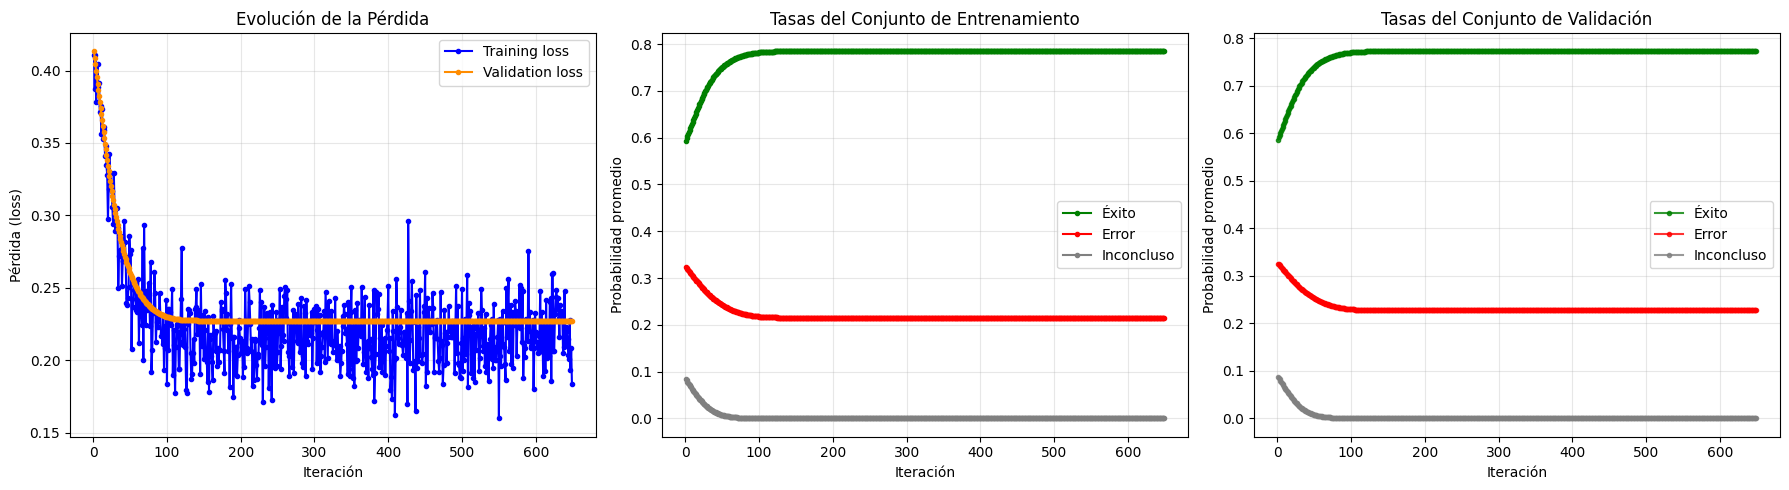

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

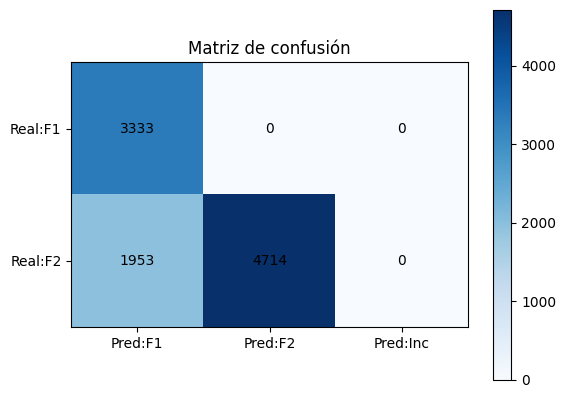

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
